In [2]:
import comet_ml
from comet_ml import Experiment

import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
import torch.nn as nn
class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with dilated convolutions
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU()
        )

        # Decoder with skip connections
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU()
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU()
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU()
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1

In [30]:
# stary training loop:

C:\Users\Adas\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/3], Training Loss: 12.3254
Epoch [1/3], Test Loss: 3.9956
Epoch [2/3], Training Loss: 8.3577
Epoch [2/3], Test Loss: 2.5330
Epoch [3/3], Training Loss: 7.5165
Epoch [3/3], Test Loss: 2.0592
Model saved at epoch 3.


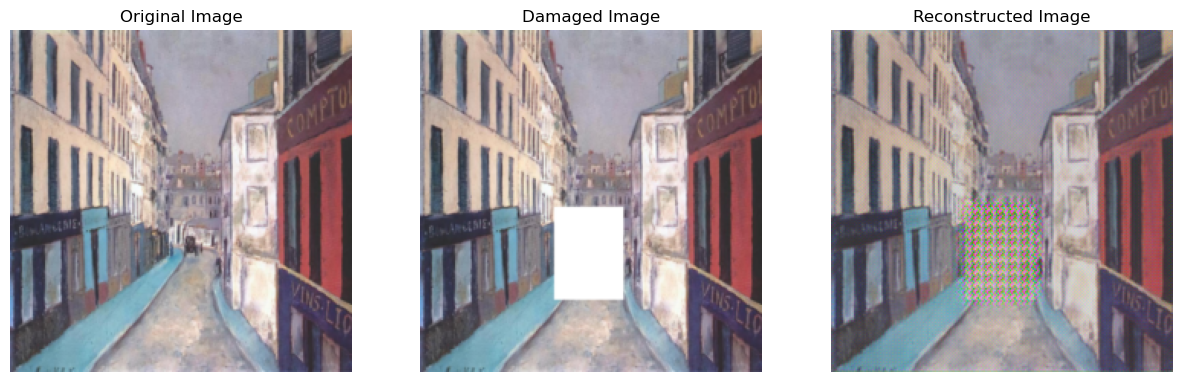

In [5]:
import comet_ml
from comet_ml import Experiment

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

# RandomMask class to damage images
class RandomMask:
    def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
        self.mask_max_size = max_size_fraction
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice

    def __call__(self, image):
        if self.mask_choice is None:
            self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
        
        im_width, im_height = image.size
        total_pixels = im_width * im_height
        target_pixels = int(total_pixels * self.mask_max_size)  # Desired damaged pixels

        if self.mask_choice == "square":
            side_length = int(target_pixels ** 0.5)
            x = random.randint(0, im_width - side_length)
            y = random.randint(0, im_height - side_length)
            image.paste((255, 255, 255), (x, y, x + side_length, y + side_length))
        
        elif self.mask_choice == "random_square":
            small_mask_size = 10  # Size of small squares
            iterations = target_pixels // (small_mask_size * small_mask_size)
            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)
                image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
        
        elif self.mask_choice == "random_polygon":
            draw = ImageDraw.Draw(image)
            num_vertices = random.randint(3, self.max_vertices)
            radius = int((target_pixels / (num_vertices * np.sin(2 * np.pi / num_vertices) * 0.5)) ** 0.5)

            # Generate a regular polygon around a random center
            center_x = random.randint(radius, im_width - radius)
            center_y = random.randint(radius, im_height - radius)
            vertices = [
                (
                    int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                    int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                )
                for i in range(num_vertices)
            ]

            # Draw the polygon
            draw.polygon(vertices, fill=(255, 255, 255))

        
        return image

# Dataset class with image masking
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        original_image = self.transform(image) if self.transform else image
        damaged_image = None

        if self.mask_transform:
            # Apply masking to the image to create a damaged version
            damaged_image = self.mask_transform(image.copy())
            damaged_image = self.transform(damaged_image) if self.transform else damaged_image

        return original_image, damaged_image

from torchvision.models import vgg16
from torchvision import transforms
import torch.nn.functional as F

class PerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Use VGG16 pretrained on ImageNet
        vgg = vgg16(weights='IMAGENET1K_V1')  # For PyTorch >=1.12
        self.feature_extractor = torch.nn.Sequential(*list(vgg.features[:16]))  # Extract features up to conv3_3
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze VGG weights

    def forward(self, input, target, mask=None, weight=10.0):
        # Normalize input and target for VGG
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(input.device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(input.device)
        input = (input - vgg_mean) / vgg_std
        target = (target - vgg_mean) / vgg_std

        # Extract features
        input_features = self.feature_extractor(input)
        target_features = self.feature_extractor(target)

        # Compute MSE loss on feature maps
        feature_loss = F.mse_loss(input_features, target_features, reduction='none')  # Element-wise loss

        if mask is not None:
            # Downsample the mask to match the feature map size
            mask = F.interpolate(mask, size=input_features.shape[2:], mode='bilinear', align_corners=False)
            mask = mask.expand_as(feature_loss)  # Ensure mask matches feature loss shape
            weighted_loss = (1 + mask * (weight - 1)) * feature_loss
            return weighted_loss.mean()  # Mean over all elements

        return feature_loss.mean()  # Default to unweighted perceptual loss



def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define perceptual loss function and optimizer
    criterion = PerceptualLoss().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            _, reconstructed_images = autoencoder(damaged_images)

            # Create a mask for penalizing inpainted regions
            #mask = (damaged_images == 255).all(dim=1, keepdim=True).float()  # Binary mask for white pixels (damaged regions)
            mask = (damaged_images == 1.0).all(dim=1, keepdim=True).float()


            # Scale the mask from [0, 255] to [0, 1] if necessary
            if damaged_images.max() > 1.0:
                damaged_images = damaged_images / 255.0

            # Calculate perceptual loss with mask
            loss = criterion(reconstructed_images, original_images, mask=mask, weight=10.0)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")
        train_loss = epoch_loss / len(train_loader)
        #experiment.log_metric("train_loss", train_loss, step=epoch+1)

        current_lr = optimizer.param_groups[0]['lr']
        #experiment.log_metric("learning_rate", current_lr, step=epoch+1)

        # Step the learning rate scheduler
        scheduler.step(train_loss)

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                _, reconstructed_images = autoencoder(damaged_images)

                # Calculate perceptual loss without mask for testing
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.4f}")
        #experiment.log_metric("test_loss", test_loss / len(test_loader), step=epoch+1)

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")



# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()



#experiment = Experiment(
#    api_key="8mxmnaeDwD4ZptsywLhhkoC53",  
#    project_name="adv_autoencoder-training_3w_maska_cluster2",
#    workspace="un"  
#)
# Main function
if __name__ == "__main__":
    
    csv_file = "clusters_csv/validated_csv_cluster_2.csv"
    root_dir = r"C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master"
    save_path = "cluster2_old_method_dobry_auto_perceptular_loss.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    mask_transform = RandomMask(max_size_fraction=1/18, max_vertices=8, mask_choice="square")

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_transform=mask_transform)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    
    autoencoder = InpaintingAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    #experiment.log_parameters({
        #"epochs": 150,
        #"batch_size": 16,
        #"learning_rate": 0.001,
        #"train_size": train_size,
        #"test_size": test_size
    #})
    
    # Start or resume training
    start_epoch = 0
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    # Train the autoencoder
    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=3, start_epoch=start_epoch)
    #experiment.end()
    
    # Visualize some images
    original_image, damaged_image = next(iter(test_loader))  # Get one batch
    original_image = original_image[0:1]  # Select the first image
    damaged_image = damaged_image[0:1]  # Select the first damaged image
    _, reconstructed_image = autoencoder(damaged_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)


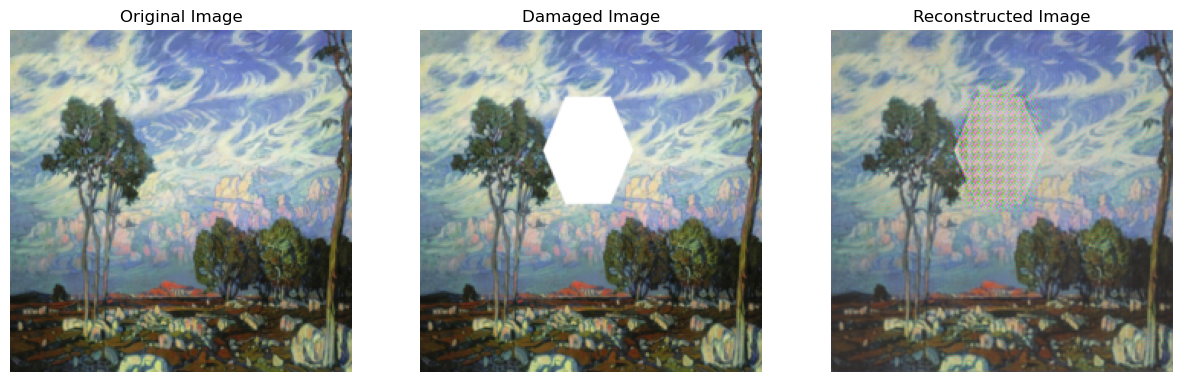

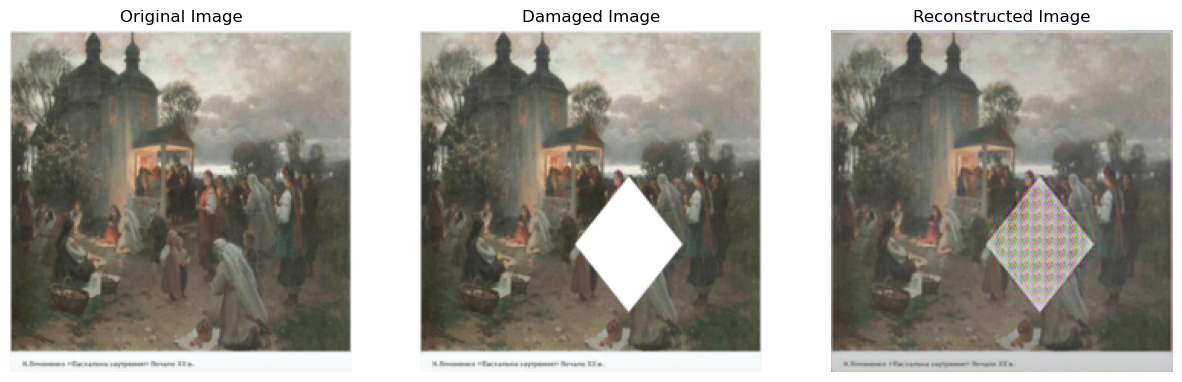

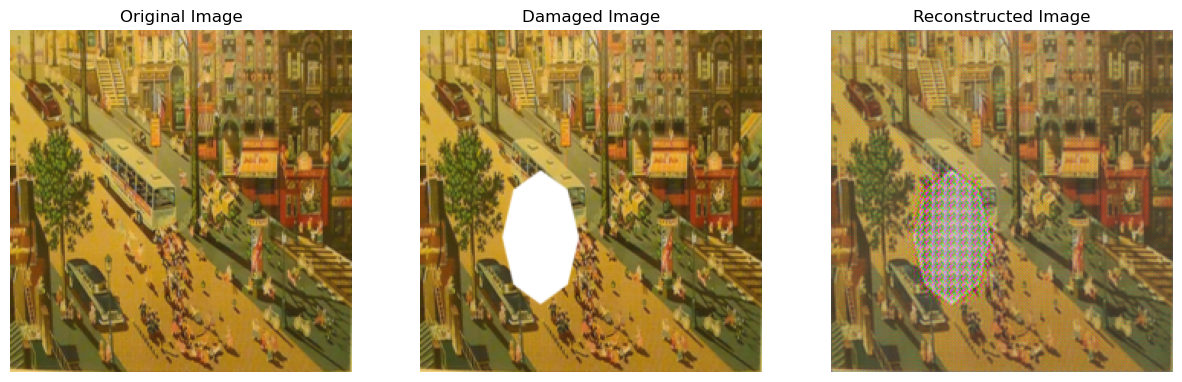

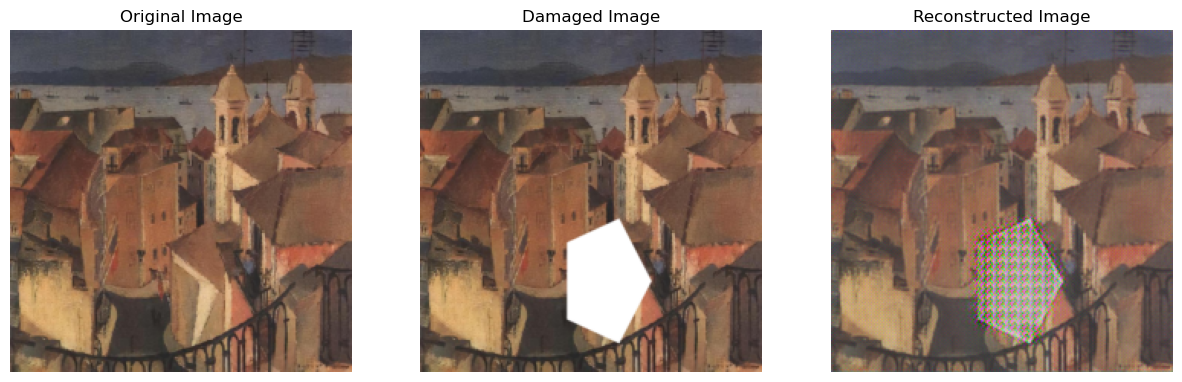

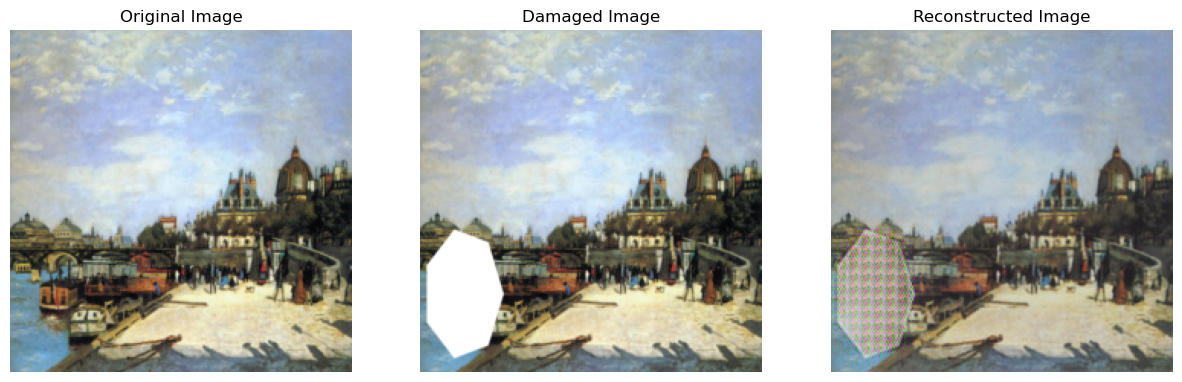

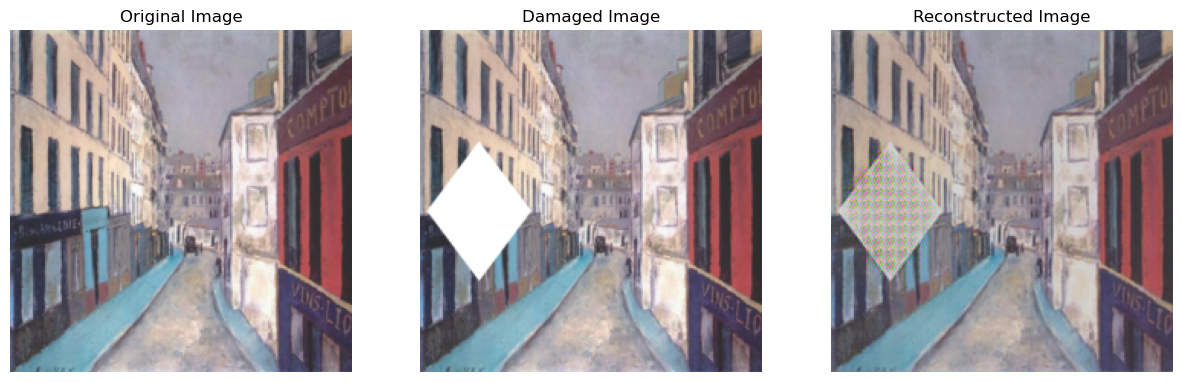

In [6]:
# Visualize a specific image from the dataset
def visualize_fixed_image(autoencoder, dataset, index=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder.eval()  # Set the autoencoder to evaluation mode

    # Get the fixed image (original and damaged) using the specified index
    original_image, damaged_image = dataset[index]

    # Add a batch dimension to the image tensors
    original_image = original_image.unsqueeze(0).to(device)
    damaged_image = damaged_image.unsqueeze(0).to(device)

    # Generate reconstructed image
    with torch.no_grad():
        _, reconstructed_image = autoencoder(damaged_image)

    # Visualize the result
    visualize_images(original_image, damaged_image, reconstructed_image)

# Main function continued
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    mask_transform = RandomMask(max_size_fraction=1/16, max_vertices=8, mask_choice="random_polygon")

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_transform=mask_transform)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  # You can use any fixed integer seed
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Ensure reproducibility by fixing the random seed
    random.seed(41)
    torch.manual_seed(42)
    #autoencoder = Autoencoder()
    # Visualize a fixed image (e.g., the first one in the test dataset)
    for i in range (5,10):
        visualize_fixed_image(autoencoder, test_dataset, index=i)
    visualize_fixed_image(autoencoder, test_dataset, index=0)
